In [1]:
#!pip install lime
#!pip install shap
#!pip install anchor-exp
#!pip install hyperopt

import pandas as pd
import numpy as np

import xgboost as xgb
from xgboost import XGBClassifier

import pickle

import sklearn
from sklearn.metrics import f1_score


import os
import joblib

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

import statistics
import scipy as scp
import math

import lime
import lime.lime_tabular

import shap

from anchor import anchor_tabular

import seaborn as sns

import random

import distutils

In [2]:
PATH = os.getcwd()

dataset = "diabetes"
cls_method = "xgboost"
classification = True
#quartiles = 1
#percentage = 0.1

num_bins = 4
bin_type = "Quartiles" if num_bins == 4 else "Deciles"

random_state = 39
exp_iter = 10
random.seed(random_state)

save_to = "%s/%s/" % (PATH, dataset)
dataset_folder = "%s/datasets/" % (save_to)
final_folder = "%s/%s/" % (save_to, cls_method)

#Get datasets
X_train = pd.read_csv(dataset_folder+dataset+"_Xtrain.csv", index_col=False, sep = ";")
test_x = pd.read_csv(final_folder+"test_sample.csv", index_col=False, sep = ";").values

cls = joblib.load(save_to+cls_method+"/cls.joblib")
X = np.vstack((X_train.values, test_x))

feat_list = [each.replace(' ','_') for each in X_train.columns]

In [3]:
if cls_method == "xgboost":
    shap_explainer = shap.Explainer(cls)
else:
    shap_explainer = shap.Explainer(cls, X, check_additivity = False)

all_bin_sizes = [[] for i in range(num_bins)]
    
for instance in test_x:
    instance = instance.reshape(1, -1) if cls_method == "xgboost" else instance
    full_exp = [shap_explainer(instance, check_additivity = False).values for i in range(exp_iter)]

    if classification==True and cls_method == "decision_tree":
        shap_exp = []
        for each in full_exp:
            single_exp = [feat[0] for feat in each]
            shap_exp.append(single_exp)
    else:
        shap_exp = [exp.reshape(len(feat_list)) for exp in full_exp]

    avg_shap_exp = np.average(shap_exp, axis = 0)

    abs_exp = [abs(exp) for exp in avg_shap_exp]

    bins = pd.cut(abs_exp, num_bins, retbins = True, duplicates = "drop")
    
    bin_feats = []
    
    for i in range(len(bins[1])-1):
        items = [val for val in abs_exp if val > bins[1][i]]
        bin_feats.append(len(items))
        
    bin_feats.reverse()
    #print(bin_feats)
    
    cumulative = bin_feats[0]
    all_bin_sizes[0].append(bin_feats[0]/len(feat_list))
    for i in range(1,len(bin_feats)):
        bin_items = bin_feats[i] - cumulative
        cumulative += bin_items
        all_bin_sizes[i].append(bin_items/len(feat_list))
        
avg_shap_bin_sizes = np.average(all_bin_sizes, axis = 1)
cumulative_shap_bin_sizes = [avg_shap_bin_sizes[0]]
cumulative_shap_bin_sizes.extend(avg_shap_bin_sizes[i]+cumulative_shap_bin_sizes[i-1] for i in range(1, num_bins))

In [4]:
if classification==True:
    class_names=['Negative','Positive']# negative is 0, positive is 1, 0 is left, 1 is right
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names = feat_list, 
                                                            class_names=class_names, discretize_continuous=True)
else:
    class_names = ['Final Value']
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names = feat_list, 
                                                            class_names=class_names, discretize_continuous=True, mode = "regression")
all_bin_sizes = [[] for i in range(num_bins)]
    
for instance in test_x:
    lime_exp = []
    for i in range(exp_iter):
        if classification==True:
            lime_exp.extend(lime_explainer.explain_instance(instance, cls.predict_proba, 
                                                num_features=len(feat_list), labels=[0,1]).as_list())
        else:
            lime_exp.extend(lime_explainer.explain_instance(instance, cls.predict, 
                                                    num_features=len(feat_list), labels=[0,1]).as_list())
            
    weights = [[] for each in feat_list]
    for exp in lime_exp:
        feat = exp[0].replace("= ",'')
        if '<' in feat:
            parts = feat.split('<')
        elif '>' in feat:
            parts = feat.split('>')
        
        for part in parts:
            if part.replace('.','').replace(' ','').isdigit()==False:
                feat_name = part.replace(' ','')
        n = feat_list.index(feat_name)
        weights[n].append(exp[1])
    
    weights = np.transpose(weights)
    avg_weight = np.average(np.array(weights), axis = 0)
    abs_weight = [abs(weight) for weight in avg_weight] 
        
    #For average explanation    
    bins = pd.cut(abs_weight, num_bins, retbins = True, duplicates = "drop")
    
    bin_feats = []
    for i in range(len(bins[1])-1):
        items = [val for val in abs_weight if val > bins[1][i]]
        bin_feats.append(len(items))
        
    bin_feats.reverse()
    
    cumulative = bin_feats[0]
    all_bin_sizes[0].append(bin_feats[0]/len(feat_list))
    for i in range(1,len(bin_feats)):
        bin_items = bin_feats[i] - cumulative
        cumulative += bin_items
        all_bin_sizes[i].append(bin_items/len(feat_list))
        
avg_lime_bin_sizes = np.average(all_bin_sizes, axis = 1)
cumulative_lime_bin_sizes = [avg_lime_bin_sizes[0]]
cumulative_lime_bin_sizes.extend(avg_lime_bin_sizes[i]+cumulative_lime_bin_sizes[i-1] for i in range(1, num_bins))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


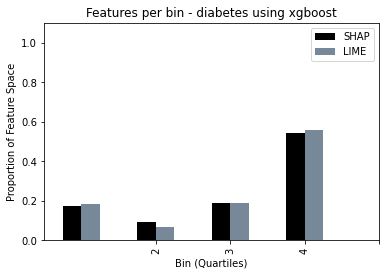

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


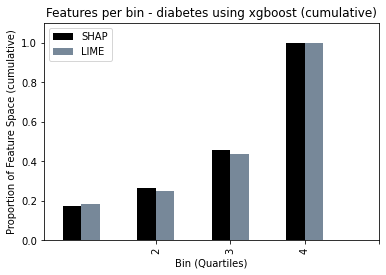

In [5]:
bins = list(range(1, num_bins+1))

df = pd.DataFrame(np.c_[avg_shap_bin_sizes, avg_lime_bin_sizes], index=bins, columns = ["SHAP", "LIME"])
df.plot.bar(color={"SHAP": "black", "LIME": "#778899"})
plt.xticks(bins)
plt.title("Features per bin - "+dataset+" using "+cls_method)
plt.xlabel("Bin ("+bin_type+")")
plt.ylabel("Proportion of Feature Space")
plt.ylim(0,1.1)
plt.savefig(final_folder+dataset+"_"+cls_method+"_"+bin_type+".eps")
plt.show()

df = pd.DataFrame(np.c_[cumulative_shap_bin_sizes, cumulative_lime_bin_sizes], index=bins, columns = ["SHAP", "LIME"])
df.plot.bar(color={"SHAP": "black", "LIME": "#778899"})
plt.xticks(bins)
plt.title("Features per bin - "+dataset+" using "+cls_method+" (cumulative)")
plt.xlabel("Bin ("+bin_type+")")
plt.ylabel("Proportion of Feature Space (cumulative)")
plt.ylim(0,1.1)
plt.savefig(final_folder+dataset+"_"+cls_method+"_"+bin_type+"_cumulative.eps")
plt.show()